In [1]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    

def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)
        
        
def show_tables():
    q = '''SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table", "view")
        '''
    return run_query(q)
rq = run_query
rc = run_command
show = show_tables
show()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Find which genres sell the most tracks in the USA

In [53]:
q1 = '''
    WITH usa_genres_data AS
    (
    SELECT
        il.invoice_line_id track_sold,
        g.name genre_name     
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON t.genre_id = g.genre_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )
    
    SELECT 
        ugd.genre_name,
        COUNT(ugd.track_sold) number_of_sold,
        CAST(COUNT(ugd.track_sold) AS FLOAT) / (
        SELECT COUNT(track_sold) FROM usa_genres_data)
        percentage        
    FROM usa_genres_data ugd
    GROUP BY 1
    ORDER BY 2 DESC
    '''

rq(q1)

,genre_name,number_of_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


                    number_of_sold  percentage
genre_name                                    
Rock                           561    0.533777
Alternative & Punk             130    0.123692
Metal                          124    0.117983
R&B/Soul                        53    0.050428
Blues                           36    0.034253
Alternative                     35    0.033302
Latin                           22    0.020932
Pop                             22    0.020932
Hip Hop/Rap                     20    0.019029
Jazz                            14    0.013321
Easy Listening                  13    0.012369
Reggae                           6    0.005709
Electronica/Dance                5    0.004757
Classical                        4    0.003806
Heavy Metal                      3    0.002854
Soundtrack                       2    0.001903
TV Shows                         1    0.000951


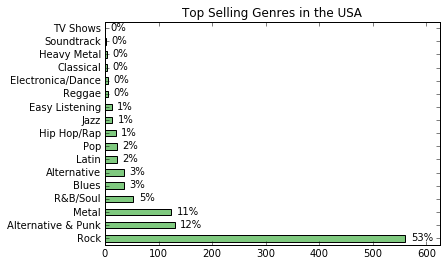

In [54]:
p1 = run_query(q1)
p1.set_index("genre_name", inplace=True, drop=True)
print(p1)

p1["number_of_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(p1.index)):
    score = p1.loc[label, "number_of_sold"]
    label = (p1.loc[label, "percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.show()

## Analyzing Agent Performance

In [55]:
q2 = '''
    WITH agent_info AS
    (
    SELECT
    *
    FROM employee e 
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    )
 
    SELECT
        first_name||" "||last_name name,
        SUM(total) total_dollar_amount,
        birthdate,
        hire_date
    FROM agent_info
    GROUP BY 1
    ORDER BY 2
    '''
rq(q2)


,name,total_dollar_amount,birthdate,hire_date
0,Steve Johnson,1393.92,1965-03-03 00:00:00,2017-10-17 00:00:00
1,Margaret Park,1584.00,1947-09-19 00:00:00,2017-05-03 00:00:00
2,Jane Peacock,1731.51,1973-08-29 00:00:00,2017-04-01 00:00:00


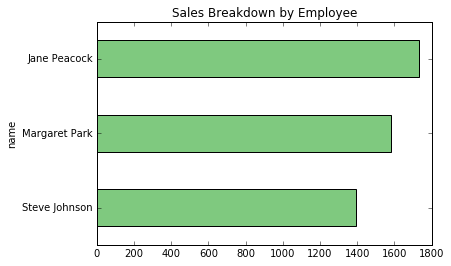

In [56]:
p2 = rq(q2)
p2.set_index("name", inplace=True, drop=True)
p2.sort_values('total_dollar_amount', inplace=True)
p2.plot.barh(
    legend = False,
    title = 'Sales Breakdown by Employee',
    colormap = plt.cm.Accent
    )


the differences in sales between three employees roughly corresponds with the differences in their hiring dates. 

## Analyzing Sales by Country

In [78]:
q3 ='''
WITH 
sup AS
(
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
),
sup_end AS
(
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM sup
    GROUP BY country
    ORDER BY sort ASC,total_sales DESC
    
)

SELECT
    country,
    total_sales,
    customers,
    average_order,
    customer_lifetime_value
FROM sup_end

    '''
    
rq(q3)

,country,total_sales,customers,average_order,customer_lifetime_value
0,USA,1040.49,13,7.942672,80.037692
1,Canada,535.59,8,7.047237,66.948750
2,Brazil,427.68,5,7.011148,85.536000
3,France,389.07,5,7.781400,77.814000
4,Germany,334.62,4,8.161463,83.655000
5,Czech Republic,273.24,2,9.108000,136.620000
6,United Kingdom,245.52,3,8.768571,81.840000
7,Portugal,185.13,2,6.383793,92.565000
8,India,183.15,2,8.721429,91.575000
9,Other,1094.94,15,7.448571,72.996000


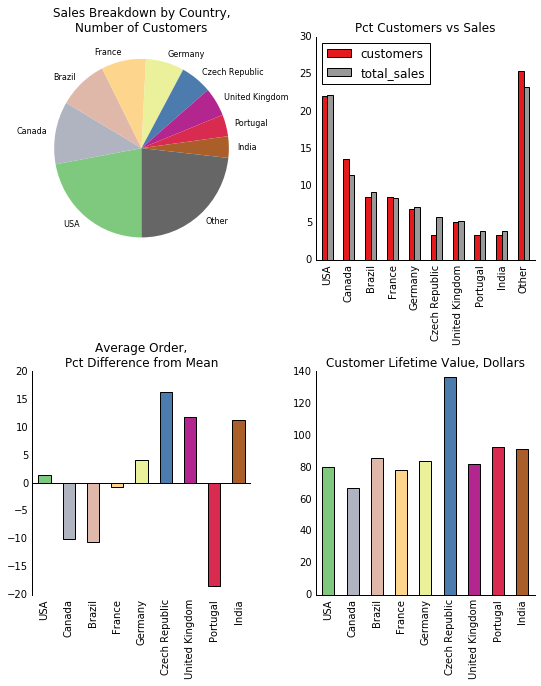

In [80]:
country_metrics = rq(q3)
country_metrics.set_index('country', inplace=True, drop=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()



In [148]:
q4 = '''
WITH 
    purchase AS
(
    SELECT 
        i.invoice_id invoice_id,
        a.title album_name,
        t.name track_name   
    FROM invoice i
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    ORDER BY i.invoice_id
),
    album_d AS
(
    SELECT 
        a.album_id,
        a.title album_name,
        t.track_id,
        t.name track_name
    FROM album a
    INNER JOIN track t ON t.album_id = a.album_id
    ORDER BY a.album_id
),
    count_table AS
(
SELECT
    invoice_id,
    album_name,
    CASE
        WHEN
            (
            SELECT a.track_name FROM album_d a 
            WHERE a.album_name = info.album_name
            EXCEPT
            SELECT p.track_name FROM purchase p
            WHERE p.invoice_id = info.invoice_id
            )IS NULL
        AND
            (
            SELECT p.track_name FROM purchase p
            WHERE p.invoice_id = info.invoice_id
            EXCEPT
            SELECT a.track_name FROM album_d a 
            WHERE a.album_name = info.album_name
            )IS NULL
        THEN 1
        ELSE 0
        END AS count
    FROM (
        SELECT 
        i.invoice_id,
        a.title album_name
    FROM invoice i
    INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    GROUP BY i.invoice_id
    ORDER BY i.invoice_id        
    ) info
)

SELECT
    CASE
        WHEN
        count=1
        THEN "Yes"
        ELSE "No"
        END AS entire_album,
    COUNT(count)  number,
    CAST(COUNT(count) AS FLOAT)/(SELECT COUNT(count) FROM count_table) percentage
FROM count_table
GROUP BY count
'''

rq(q4)

,entire_album,number,percentage
0,No,500,0.814332
1,Yes,114,0.185668


It's not wise to decide to purchase only select tracks from albums from record companies since there are nearly one fifth customers would buy the whole albums.

![Alt text](/pictures/62.jpg)